# ADIGE RIVER BASIN _ BRONZOLO

Lead time models



import sys
sys.path.append('/time_unit')

In [1]:
from sf_runoff_lt import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies


from cross_validation_f_lt import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from cross_validation_f_lt import evaluate_prediction, plot_prediction, plot_anomalies
from cross_validation_f_lt import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
#from cross_validation_f import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

import os

import pdb
import seaborn as sns

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

daily_input = pd.read_csv(path+'Etsch-Branzoll_85550PG_8555QQ0010A_19761231000000_20210721000000.csv', index_col=0, parse_dates=True)

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

In [ ]:
import sys, importlib
importlib.reload(sys.modules['nested_CV_lt'])


In [3]:
t_unit=30
lt=1


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-4, 2, 10)
epsilon_range=np.logspace(-4, 0, 5)
#n_range = [17, 50, 200]
components_range = [5*3*12]
#do not enlarge t_range for now
t_range=[12]
n_splits=10
test_size=365

In [5]:
from base_f import create_it_matrix
from sf_runoff_lt import create_it_matrix_lt

In [6]:
t_length=t_range[0]
it_matrix=create_it_matrix(daily_input,t_length,t_unit).astype('float32')

In [7]:
it_matrix_lt=create_it_matrix_lt(daily_input,t_length,t_unit,lt).astype('float32')

In [12]:
it_matrix

Q     T16_-11     T16_-10      T16_-9      T16_-8  \
1980-01-30  77.349289  271.261047  273.149292  274.433685  281.445587   
1980-01-31  77.919678  271.301788  273.029602  274.543579  281.811554   
1980-02-01  78.129692  271.315704  272.982361  274.660645  282.094696   
1980-02-02  77.564163  271.318451  273.028076  274.786713  282.309723   
1980-02-03  76.402328  271.320648  273.055786  274.964417  282.510773   
...               ...         ...         ...         ...         ...   
2018-12-27  95.362717  273.031586  269.065277  273.218262  279.635010   
2018-12-28  94.303825  273.098022  269.002563  273.339325  279.779236   
2018-12-29  92.706924  273.103149  269.026276  273.470886  279.977203   
2018-12-30  91.239647  273.015503  269.122772  273.563446  280.165771   
2018-12-31  90.124992  272.850464  269.282593  273.703217  280.347443   

                T16_-7      T16_-6      T16_-5      T16_-4      T16_-3  ...  \
1980-01-30  284.643677  288.005310  285.251923  282.879272  278.148102  ...   
1980-01-31  284.637390  288.113617  285.141449  282.722015  277.962708  ...   
1980-02-01  284.705963  288.170380  285.035370  282.569672  277.732849  ...   
1980-02-02  284.836334  288.250885  284.848602  282.433929  277.472839  ...   
1980-02-03  284.875244  288.350708  284.711700  282.290375  277.174988  ...   
...                ...         ...         ...         ...         ...  ...   
2018-12-27  283.243622  288.309662  290.326508  290.675629  286.264771  ...   
2018-12-28  283.556000  288.414429  290.426453  290.420868  286.151031  ...   
2018-12-29  283.729187  288.540314  290.565704  290.059204  286.066559  ...   
2018-12-30  283.950897  288.622681  290.662323  289.730865  285.866302  ...   
2018-12-31  284.126495  288.676483  290.811035  289.402130  285.702698  ...   

             E490_-9    E490_-8    E490_-7    E490_-6    E490_-5    E490_-4  \
1980-01-30  7.263779  34.580917  37.801231  64.851982  58.001244  37.384476   
1980-01-31  7.544704  35.867138  38.121445  64.854172  57.465748  36.832916   
1980-02-01  7.962466  36.865597  38.886688  65.862701  55.651260  36.404251   
1980-02-02  8.568475  37.044106  39.801731  66.746872  54.718296  34.942947   
1980-02-03  9.007150  36.778572  40.426086  68.443794  54.202629  32.755192   
...              ...        ...        ...        ...        ...        ...   
2018-12-27  7.487294  33.277466  38.370972  68.878036  88.239899  80.641518   
2018-12-28  8.062484  33.153759  39.891319  70.569389  89.057335  76.392349   
2018-12-29  8.548194  32.680420  41.017395  72.539253  89.350304  72.906937   
2018-12-30  8.889134  32.061584  44.300426  71.792511  89.499428  70.361008   
2018-12-31  8.970739  32.404072  45.854874  72.614296  89.792572  68.459343   

              E490_-3    E490_-2    E490_-1    E490_0  
1980-01-30  16.792503   6.086018   5.021212  2.920013  
1980-01-31  16.180950   6.038846   4.909879  3.229279  
1980-02-01  15.288921   6.393413   4.440180  3.344741  
1980-02-02  15.052187   6.264967   4.461010  3.489541  
1980-02-03  15.413444   6.211617   4.078867  3.679520  
...               ...        ...        ...       ...  
2018-12-27  49.781460  31.540163  16.241415  7.043812  
2018-12-28  50.804661  30.755793  15.641689  7.592799  
2018-12-29  51.953785  30.019197  15.377418  7.101724  
2018-12-30  51.722366  30.564562  15.197930  6.872263  
2018-12-31  51.348026  30.281670  14.606598  7.233721  

[14216 rows x 10345 columns]

In [13]:
it_matrix_lt

Q     T16_-11     T16_-10      T16_-9      T16_-8  \
1980-01-30  77.349289  271.261047  273.149292  274.433685  281.445587   
1980-01-31  77.919678  271.301788  273.029602  274.543579  281.811554   
1980-02-01  78.129692  271.315704  272.982361  274.660645  282.094696   
1980-02-02  77.564163  271.318451  273.028076  274.786713  282.309723   
1980-02-03  76.402328  271.320648  273.055786  274.964417  282.510773   
...               ...         ...         ...         ...         ...   
2018-12-27  95.362717  273.031586  269.065277  273.218262  279.635010   
2018-12-28  94.303825  273.098022  269.002563  273.339325  279.779236   
2018-12-29  92.706924  273.103149  269.026276  273.470886  279.977203   
2018-12-30  91.239647  273.015503  269.122772  273.563446  280.165771   
2018-12-31  90.124992  272.850464  269.282593  273.703217  280.347443   

                T16_-7      T16_-6      T16_-5      T16_-4      T16_-3  ...  \
1980-01-30  284.643677  288.005310  285.251923  282.879272  278.148102  ...   
1980-01-31  284.637390  288.113617  285.141449  282.722015  277.962708  ...   
1980-02-01  284.705963  288.170380  285.035370  282.569672  277.732849  ...   
1980-02-02  284.836334  288.250885  284.848602  282.433929  277.472839  ...   
1980-02-03  284.875244  288.350708  284.711700  282.290375  277.174988  ...   
...                ...         ...         ...         ...         ...  ...   
2018-12-27  283.243622  288.309662  290.326508  290.675629  286.264771  ...   
2018-12-28  283.556000  288.414429  290.426453  290.420868  286.151031  ...   
2018-12-29  283.729187  288.540314  290.565704  290.059204  286.066559  ...   
2018-12-30  283.950897  288.622681  290.662323  289.730865  285.866302  ...   
2018-12-31  284.126495  288.676483  290.811035  289.402130  285.702698  ...   

            E490_-10   E490_-9    E490_-8    E490_-7    E490_-6    E490_-5  \
1980-01-30  4.305620  7.263779  34.580917  37.801231  64.851982  58.001244   
1980-01-31  4.071145  7.544704  35.867138  38.121445  64.854172  57.465748   
1980-02-01  3.976510  7.962466  36.865597  38.886688  65.862701  55.651260   
1980-02-02  3.915358  8.568475  37.044106  39.801731  66.746872  54.718296   
1980-02-03  4.102645  9.007150  36.778572  40.426086  68.443794  54.202629   
...              ...       ...        ...        ...        ...        ...   
2018-12-27  2.918925  7.487294  33.277466  38.370972  68.878036  88.239899   
2018-12-28  2.956916  8.062484  33.153759  39.891319  70.569389  89.057335   
2018-12-29  3.401540  8.548194  32.680420  41.017395  72.539253  89.350304   
2018-12-30  3.850165  8.889134  32.061584  44.300426  71.792511  89.499428   
2018-12-31  3.779202  8.970739  32.404072  45.854874  72.614296  89.792572   

              E490_-4    E490_-3    E490_-2    E490_-1  
1980-01-30  37.384476  16.792503   6.086018   5.021212  
1980-01-31  36.832916  16.180950   6.038846   4.909879  
1980-02-01  36.404251  15.288921   6.393413   4.440180  
1980-02-02  34.942947  15.052187   6.264967   4.461010  
1980-02-03  32.755192  15.413444   6.211617   4.078867  
...               ...        ...        ...        ...  
2018-12-27  80.641518  49.781460  31.540163  16.241415  
2018-12-28  76.392349  50.804661  30.755793  15.641689  
2018-12-29  72.906937  51.953785  30.019197  15.377418  
2018-12-30  70.361008  51.722366  30.564562  15.197930  
2018-12-31  68.459343  51.348026  30.281670  14.606598  

[14216 rows x 9483 columns]

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C=0.21544346900318823
eps=0.1
n=180


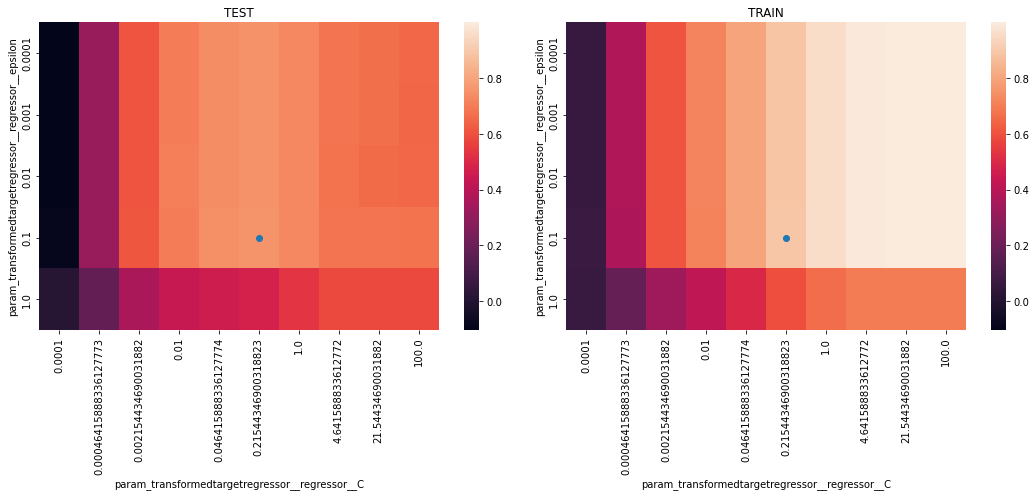

In [14]:
C,eps,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C={C}')
print(f'eps={eps}')
print(f'n={n}')

In [15]:
C=0.21544346900318834
eps=0.01
n=180

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [16]:
radius_for_ensemble = 1
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps, n, 12, t_unit, n_splits, test_size, radius_for_ensemble,lt)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

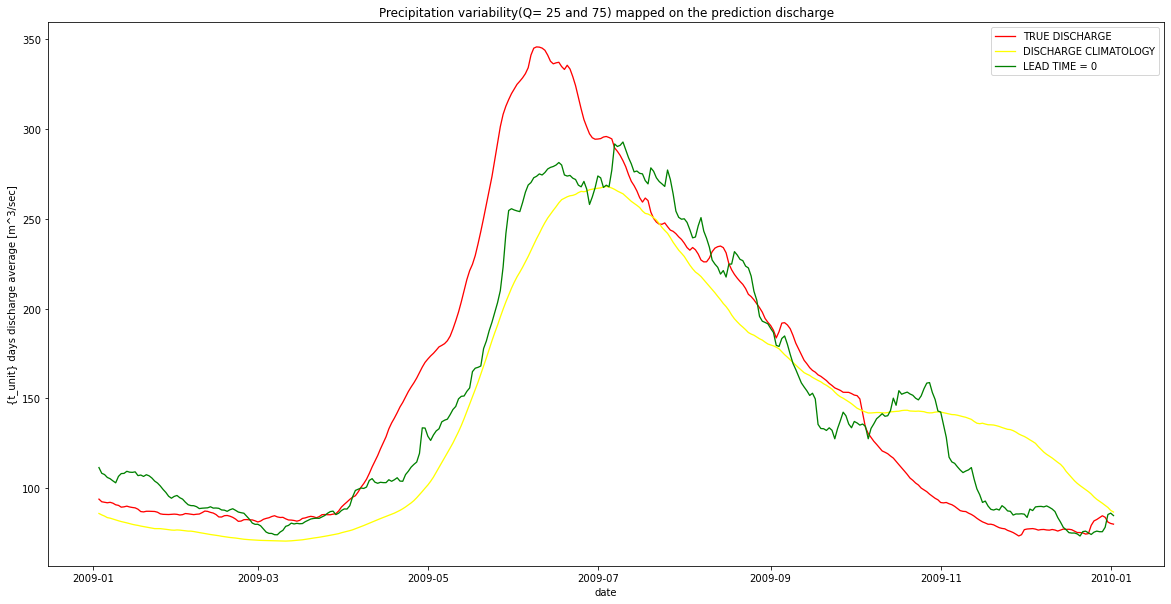

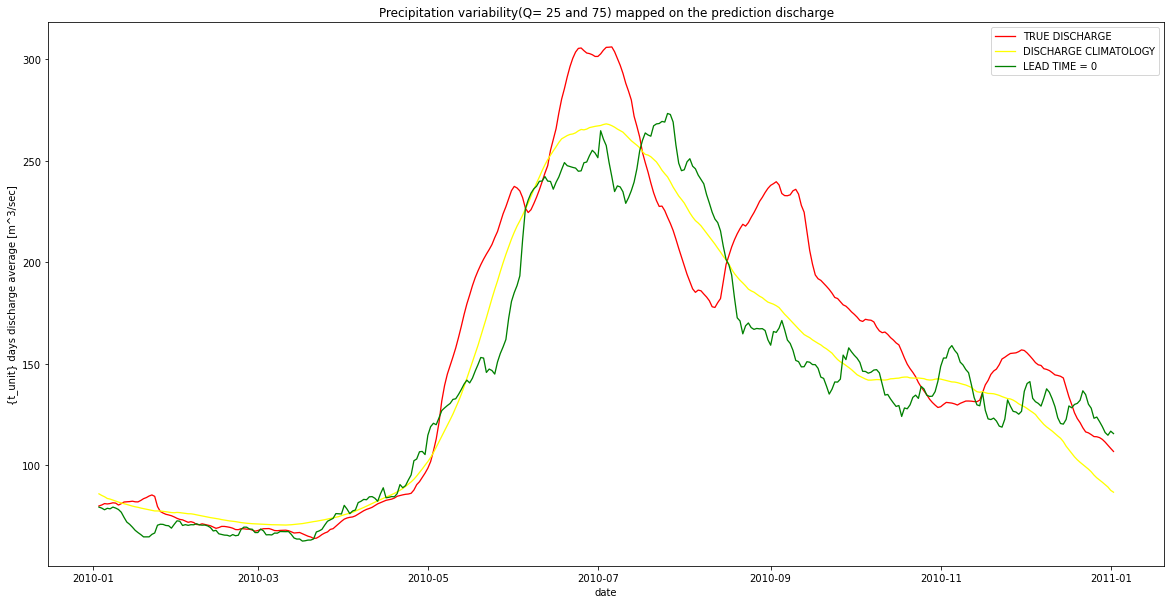

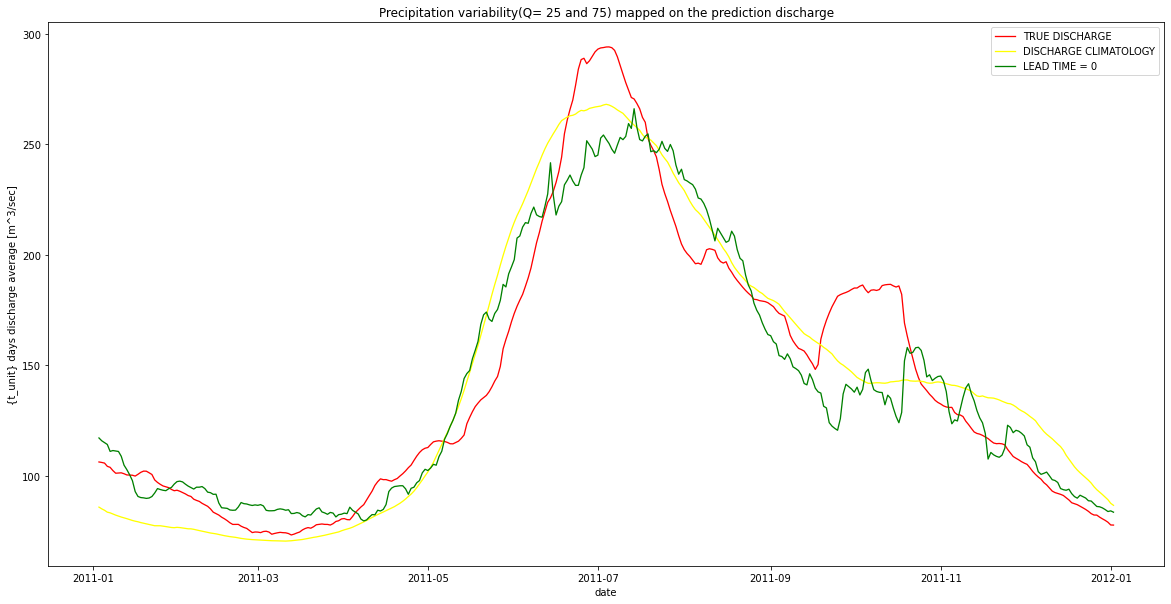

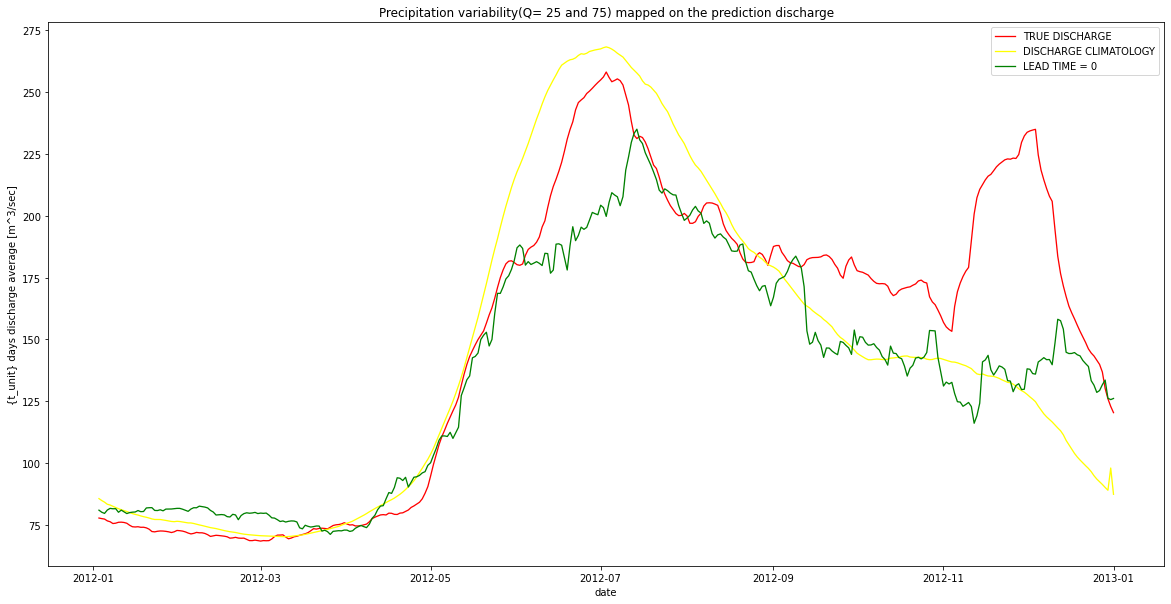

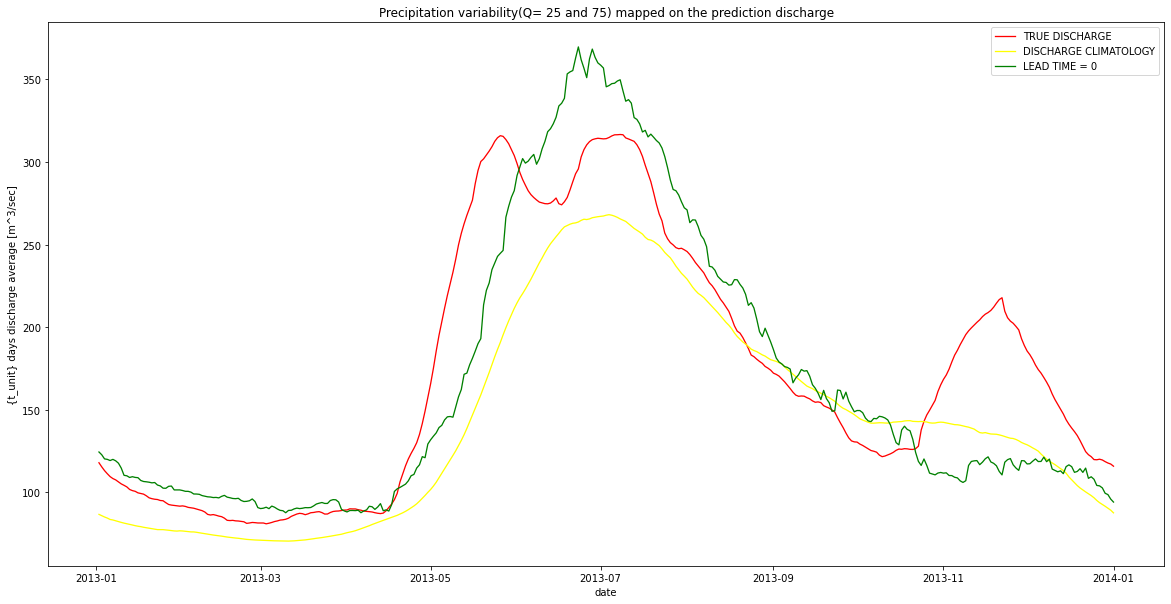

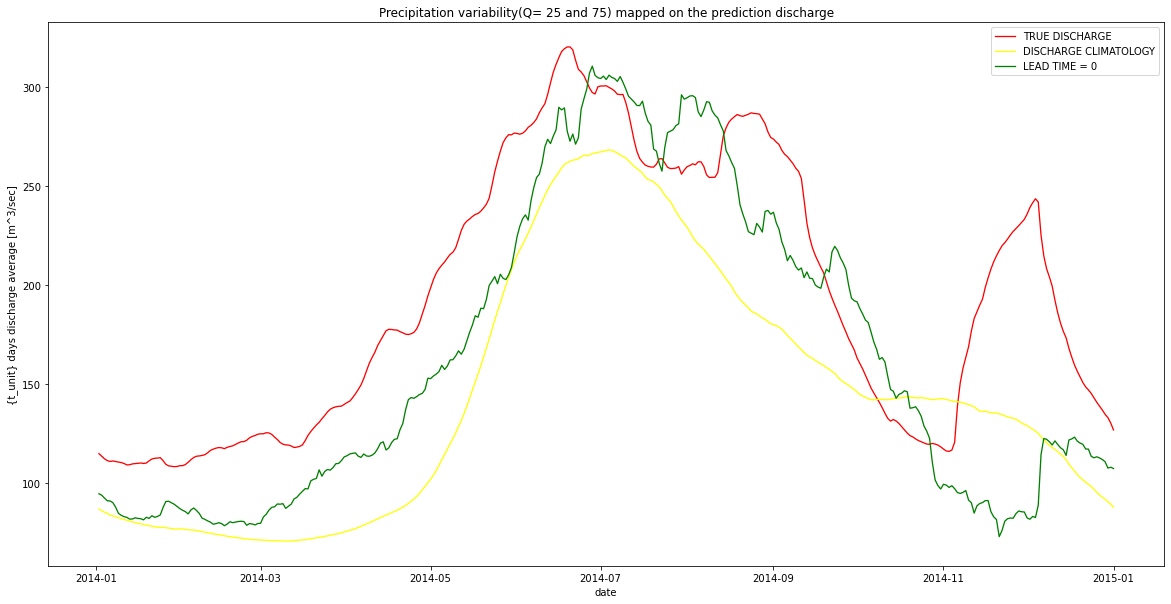

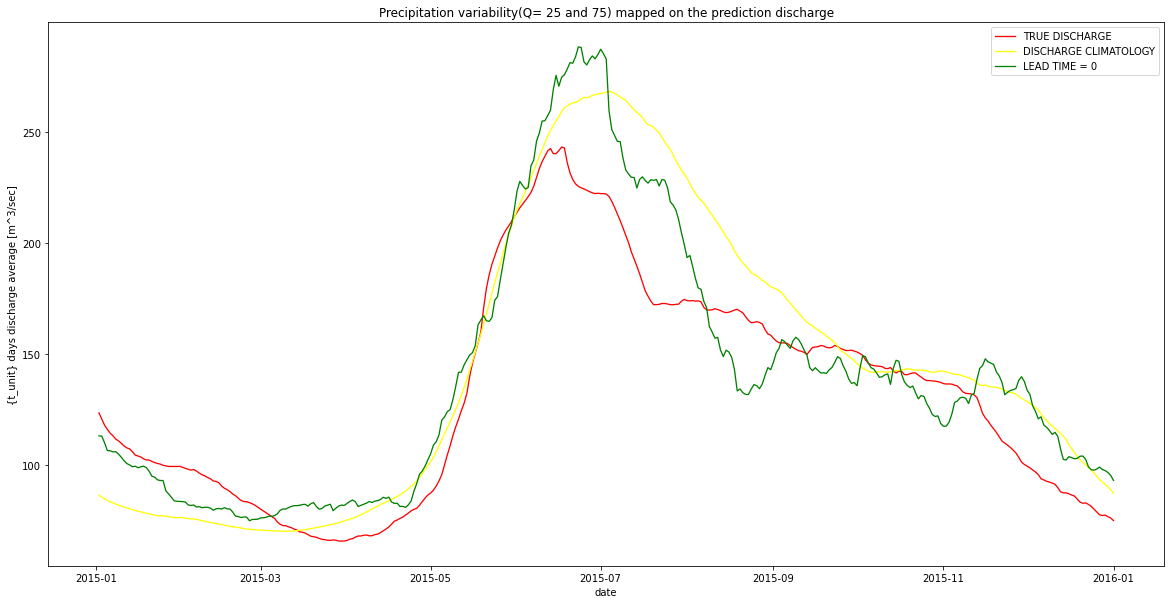

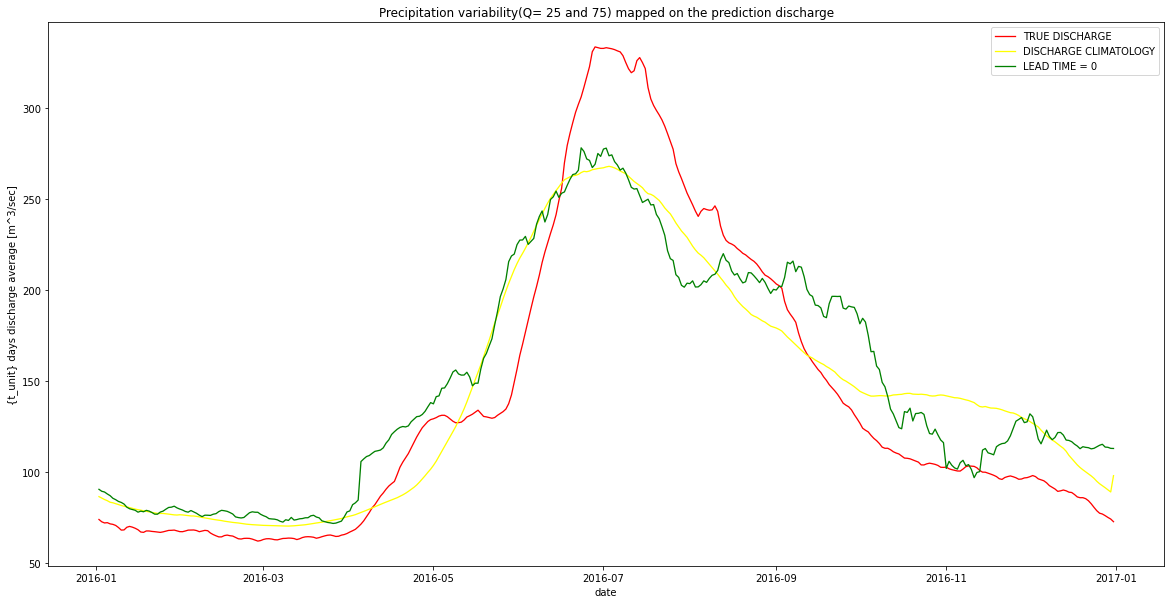

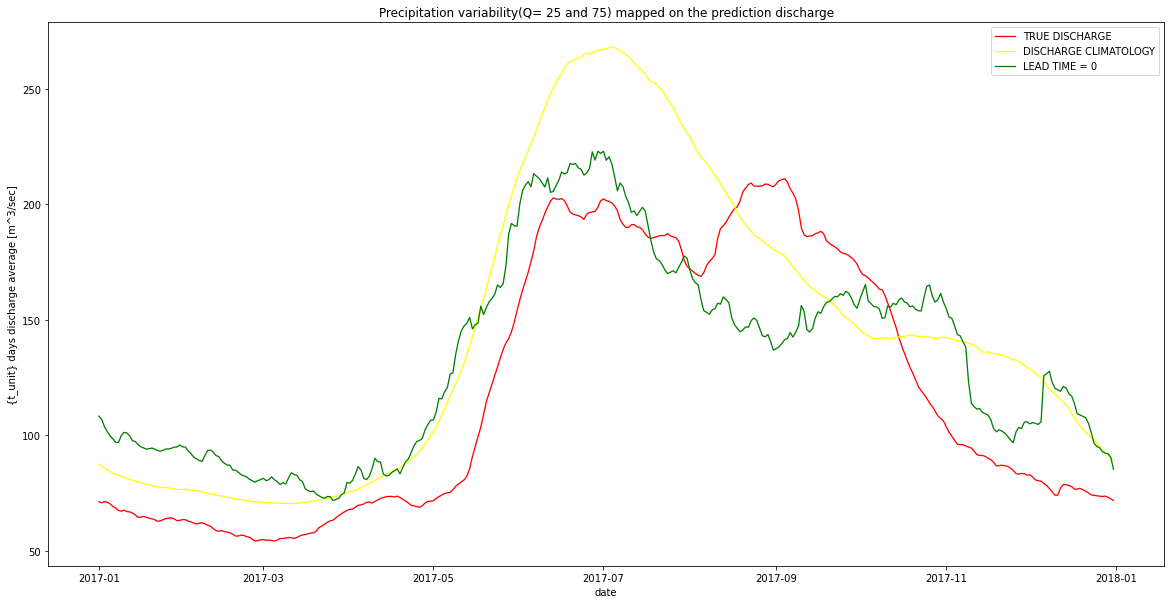

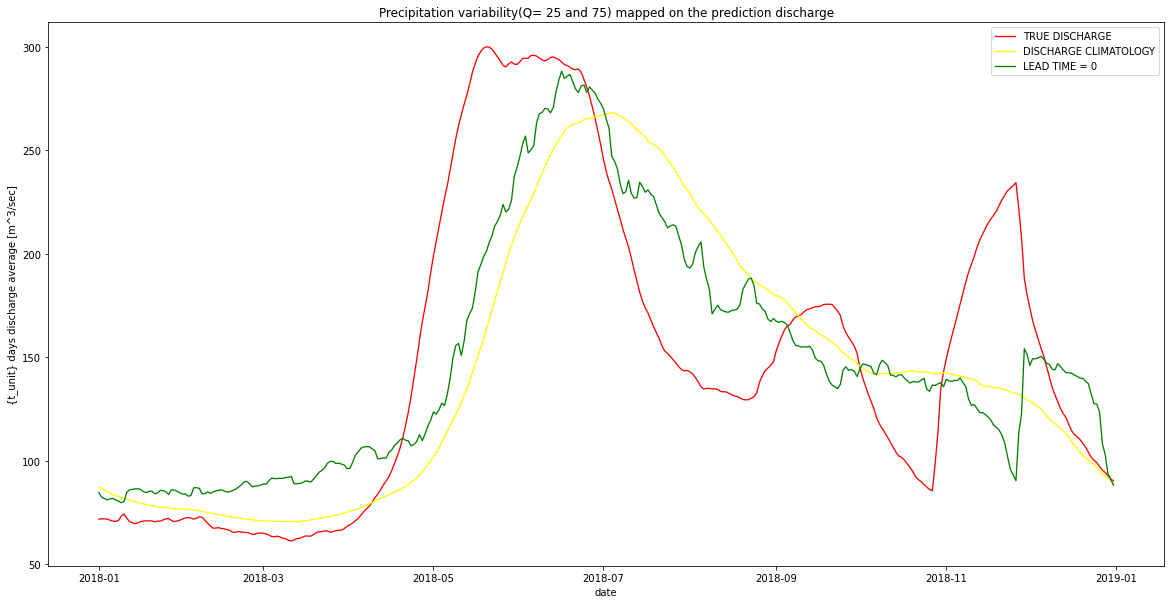

In [17]:
plot_prediction(predictions,t_unit)

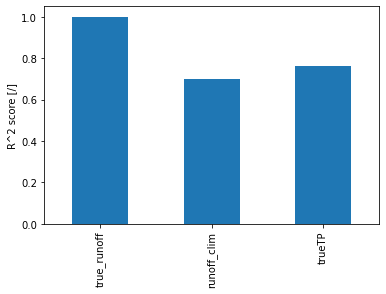

In [18]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits)

In [ ]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split
plot_anomalies(a,t_unit)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C=0.21544346900318823
epsilon=0.1
n=36


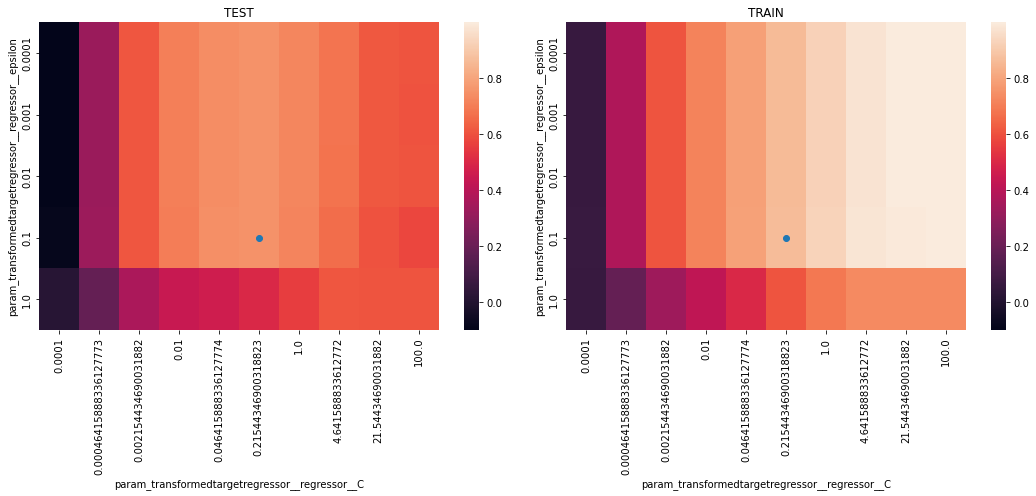

In [19]:
components_range2=[12*3]
C2,eps2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range2, t_range,t_unit, n_splits,test_size,lt)
print(f'C={C2}')
print(f'epsilon={eps2}')
print(f'n={n2}')

In [20]:
C2=0.5994842503189409
eps2=0.01
n2=36

C2  =0.5994842503189409
eps2=10e-06
n2  =36

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [21]:
radius_for_ensemble = 1
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

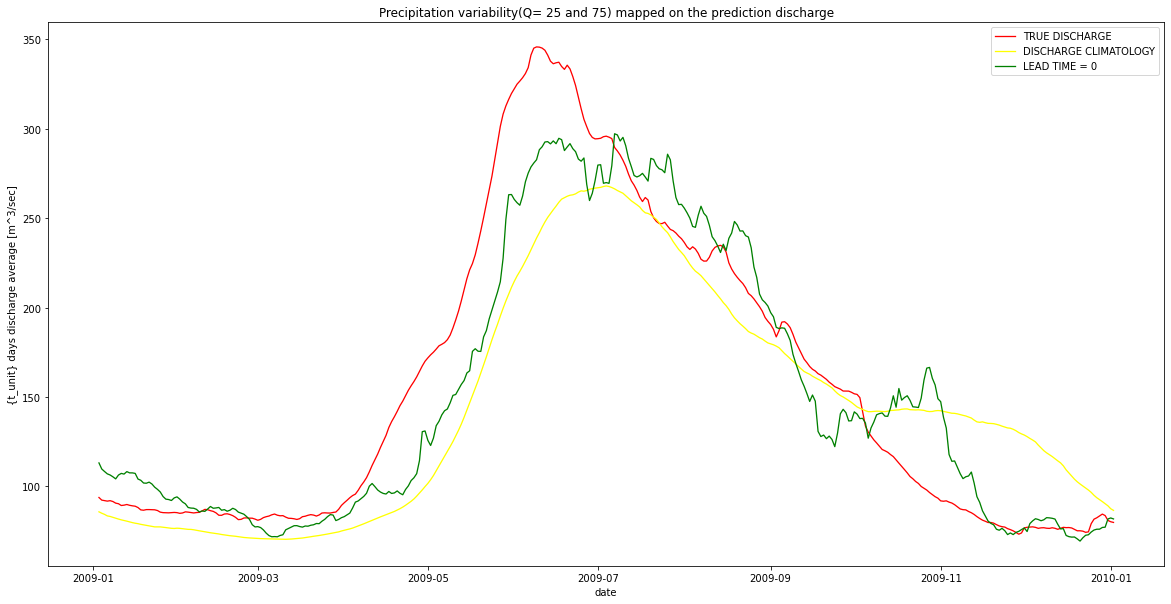

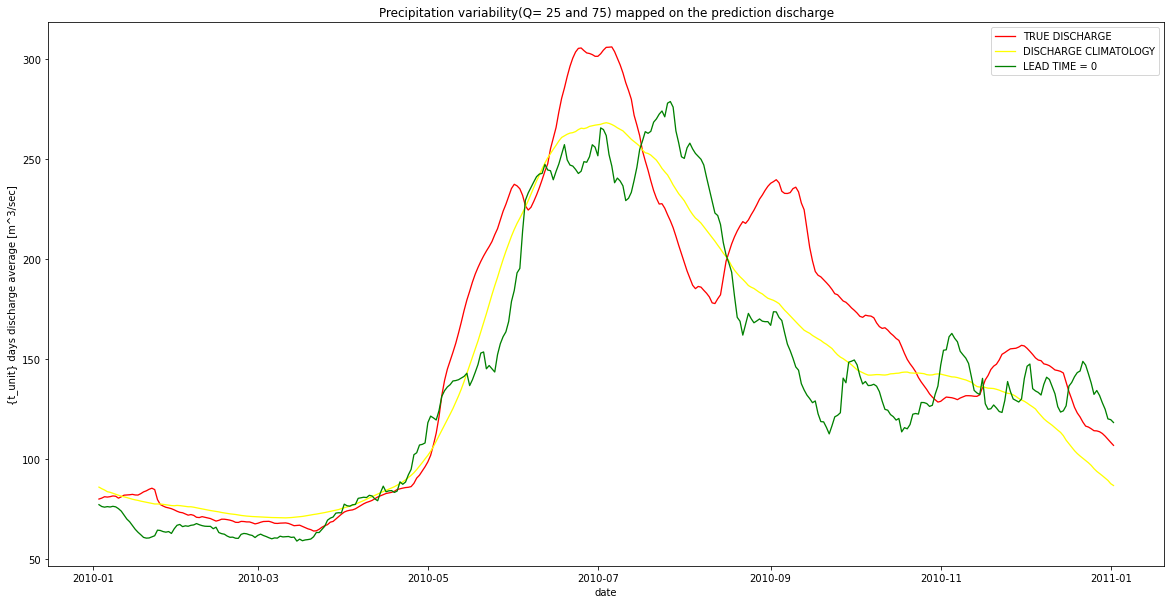

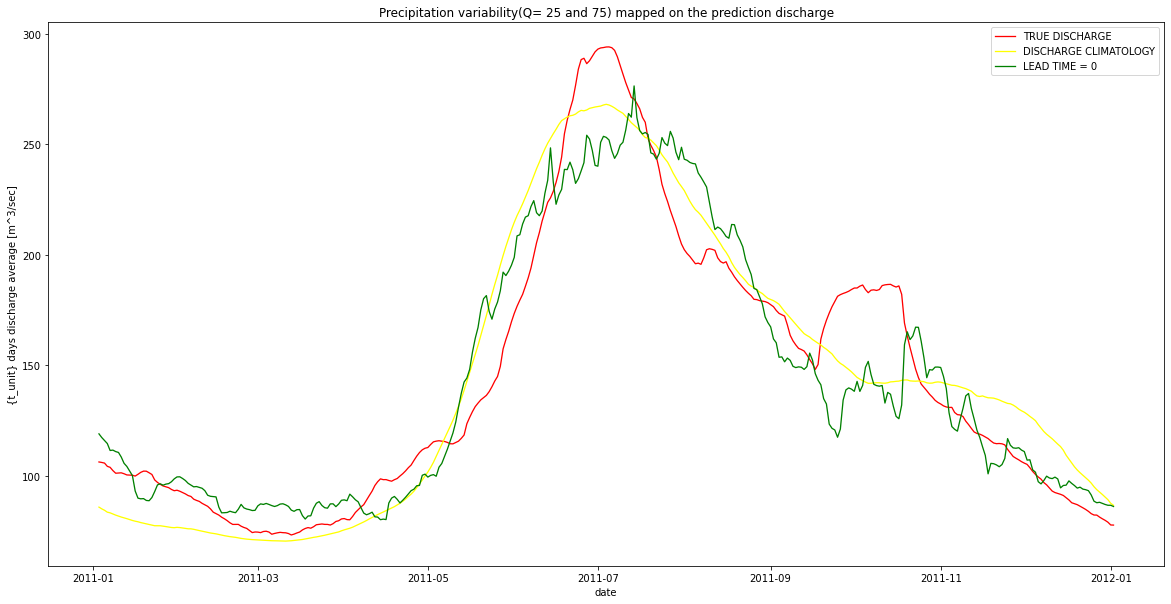

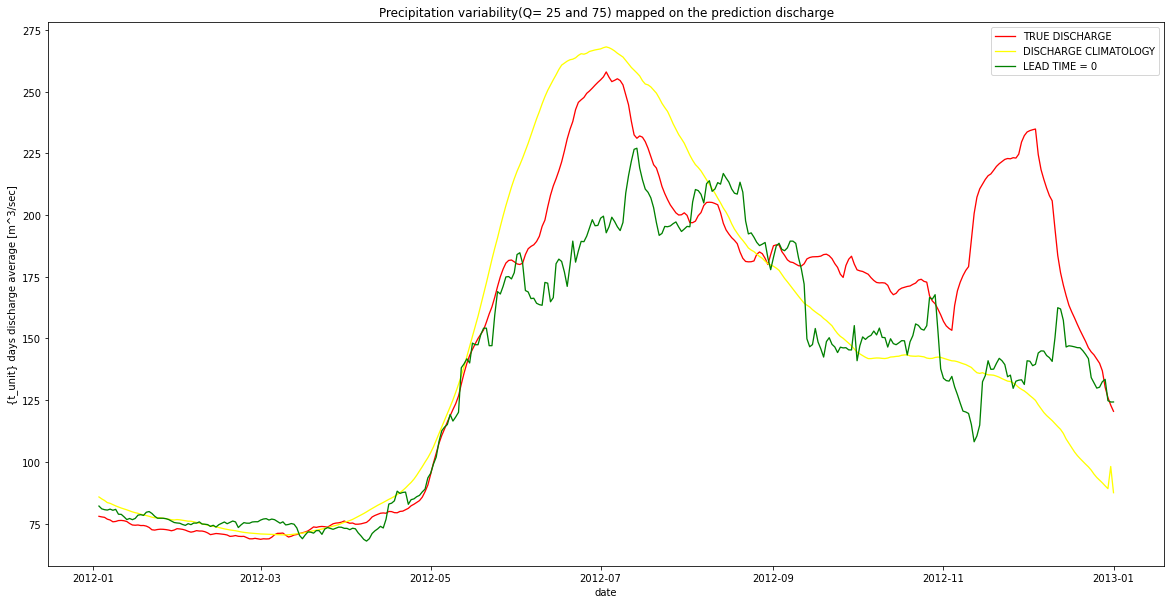

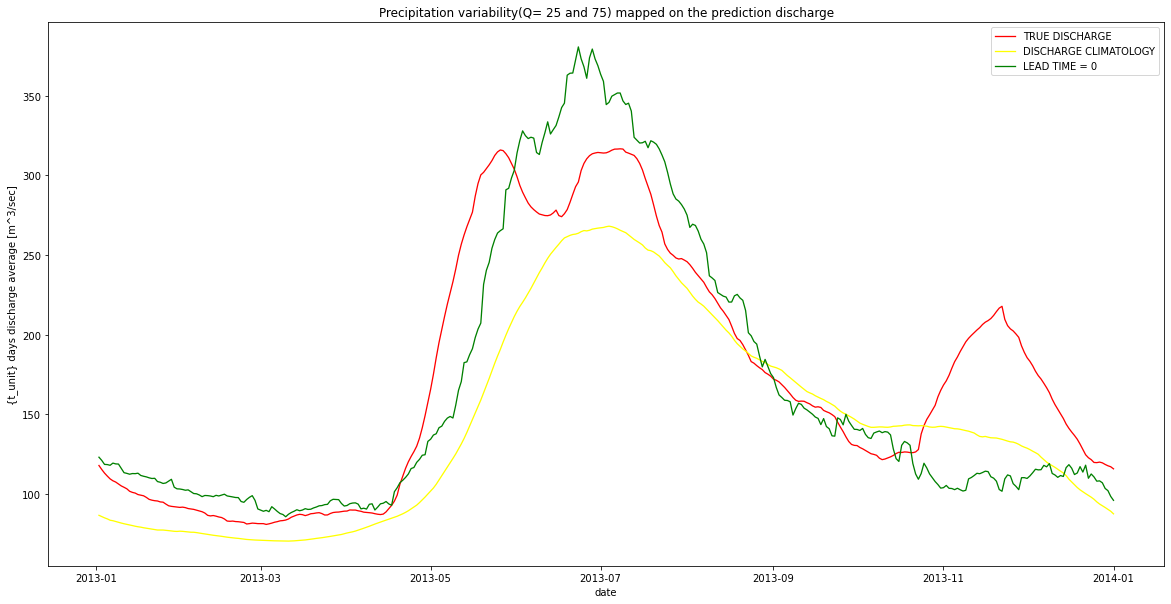

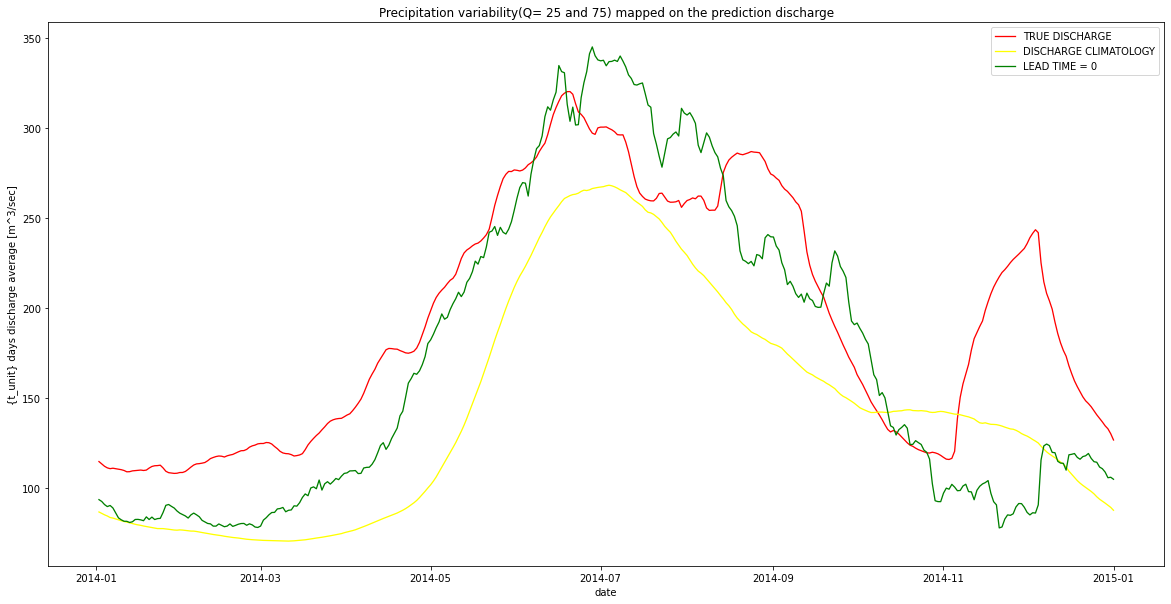

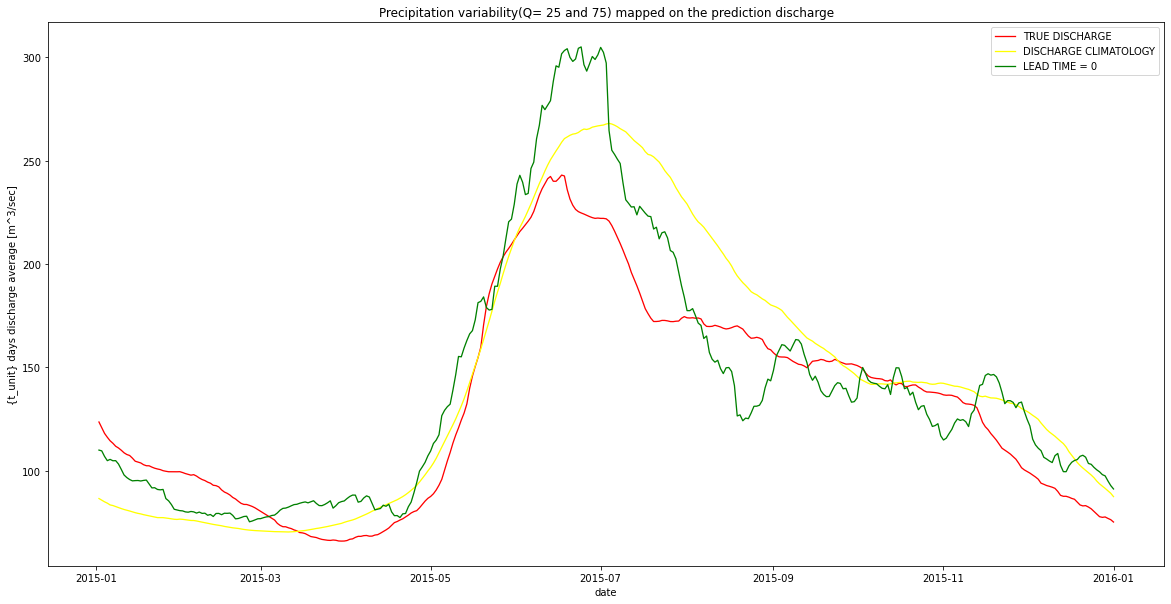

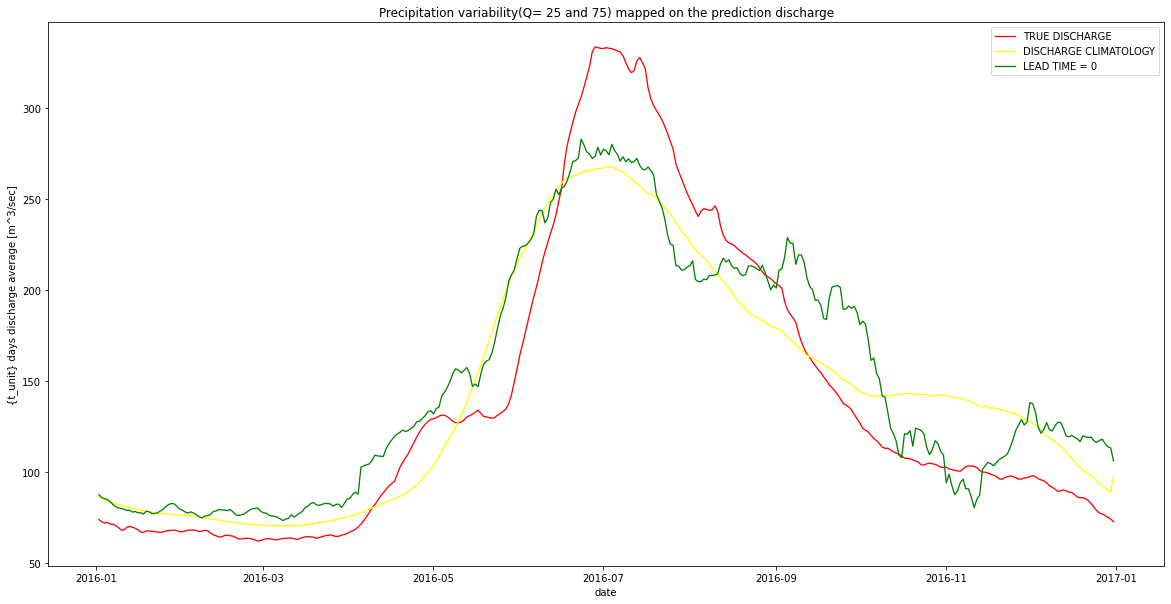

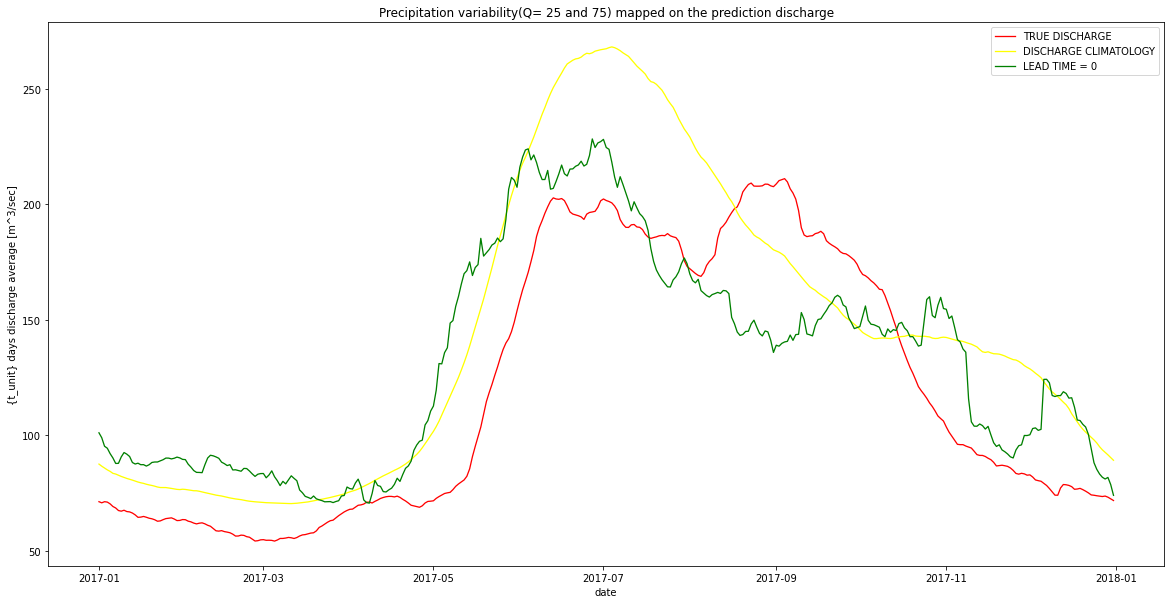

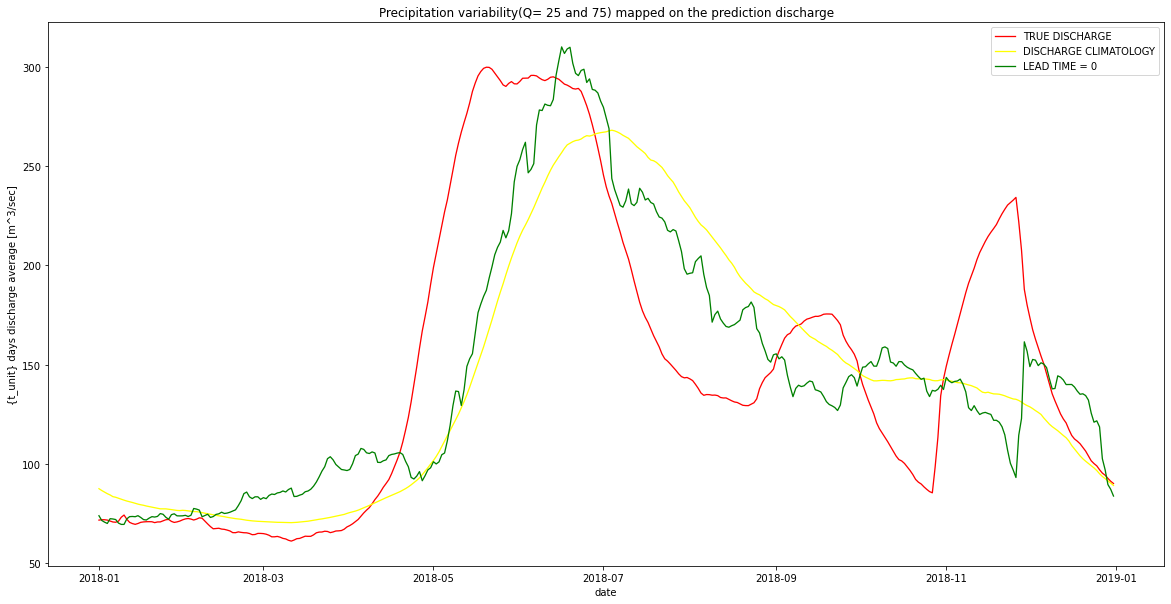

In [22]:
plot_prediction(predictions2,t_unit)

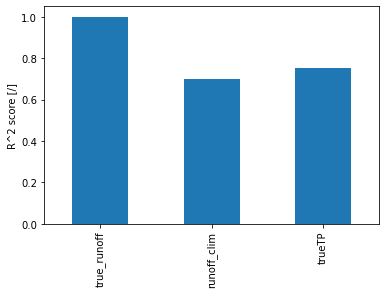

In [23]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits)
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


In [ ]:
climatologies2=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split
plot_anomalies(a2,t_unit)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



C3=0.21544346900318823
eps3=0.1


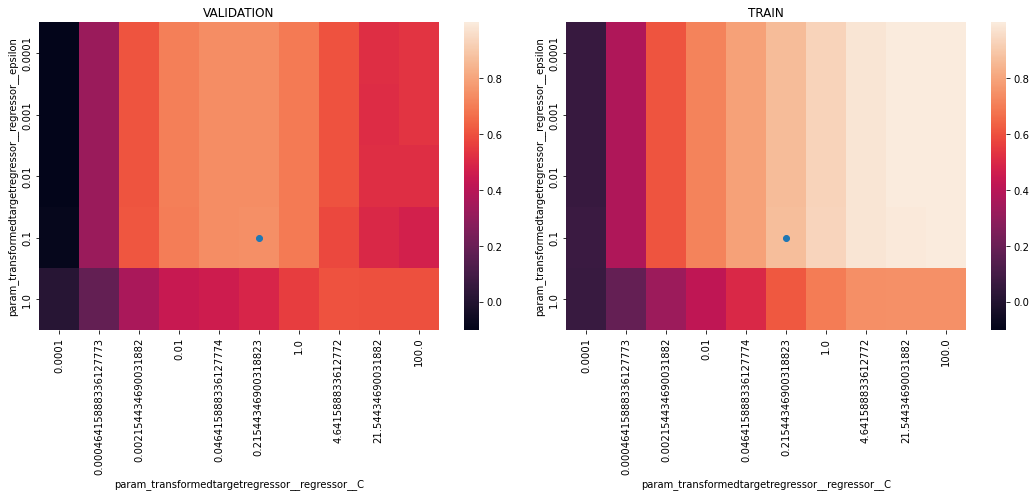

In [24]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [25]:
C3=0.5994842503189409
eps3=7.742636826811277e-06

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [26]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

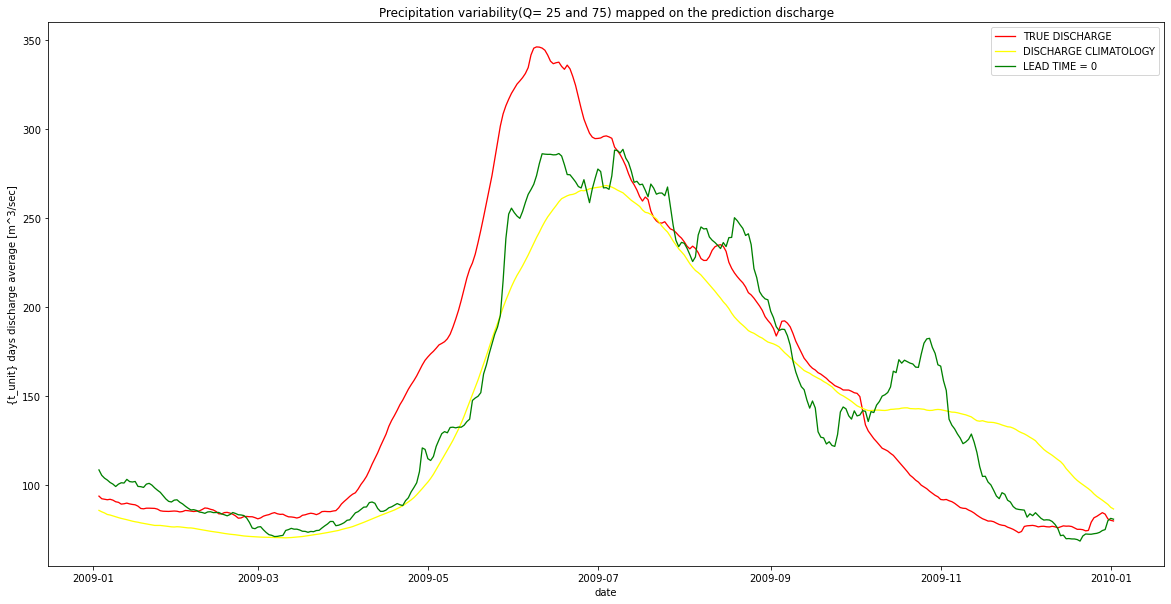

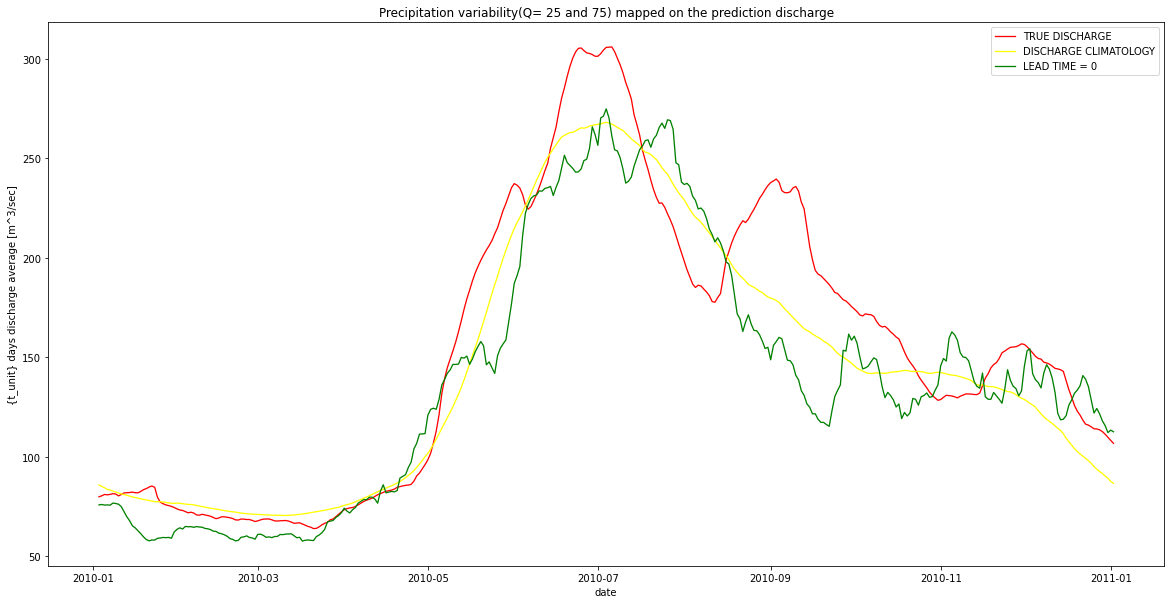

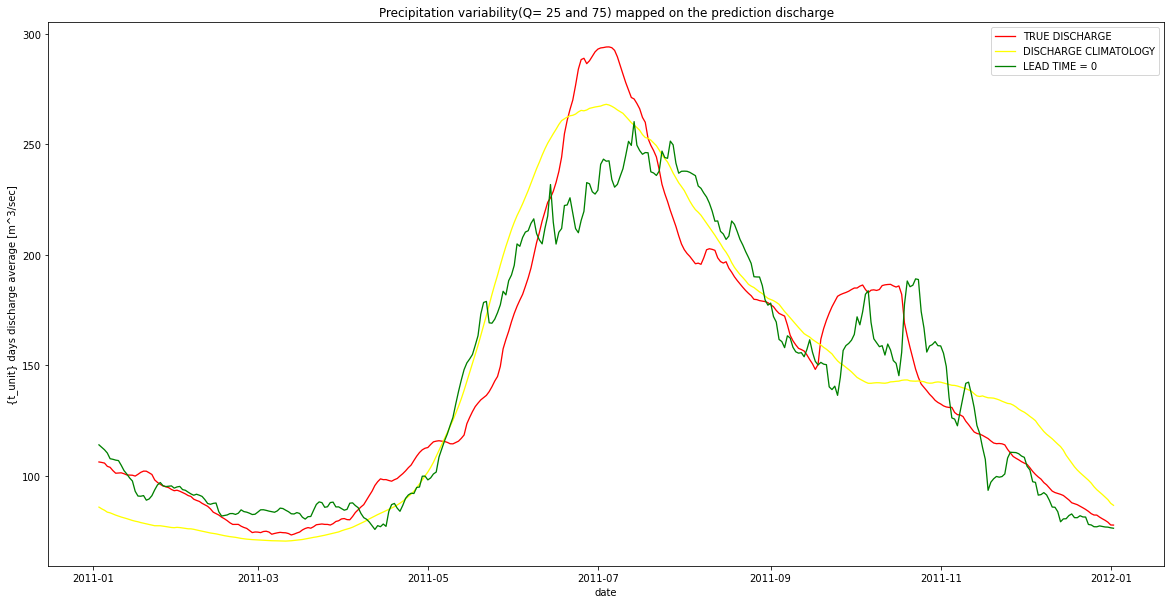

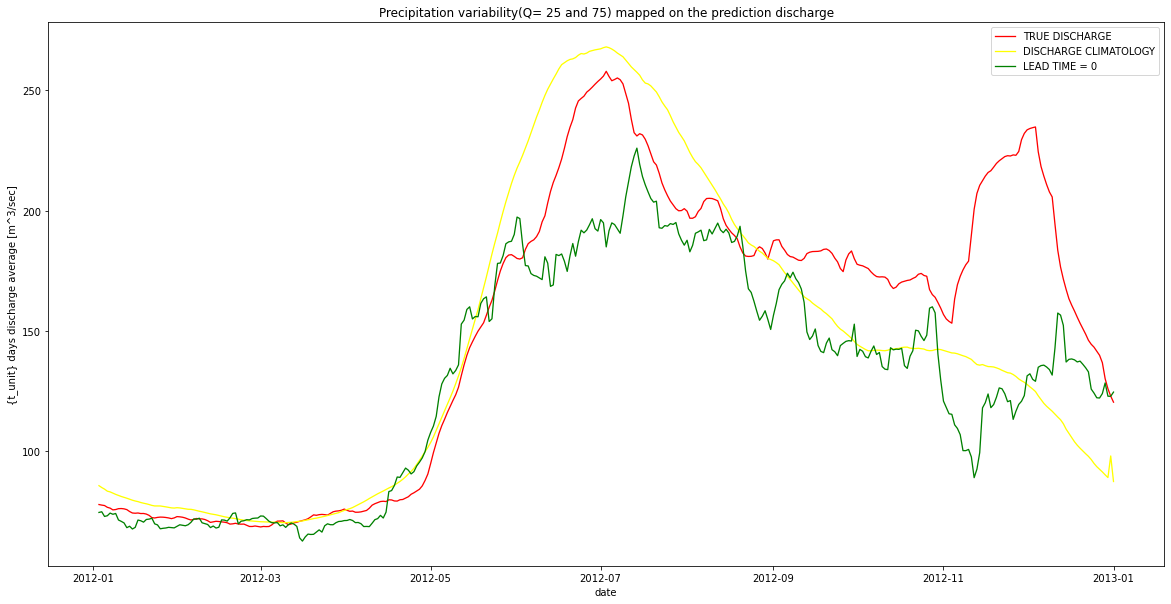

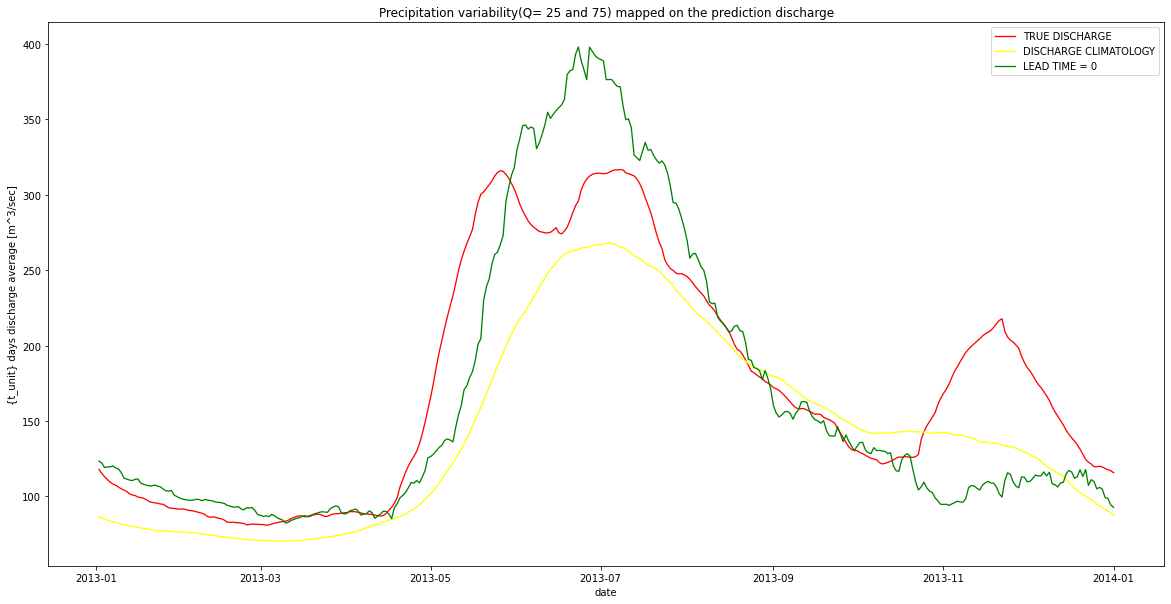

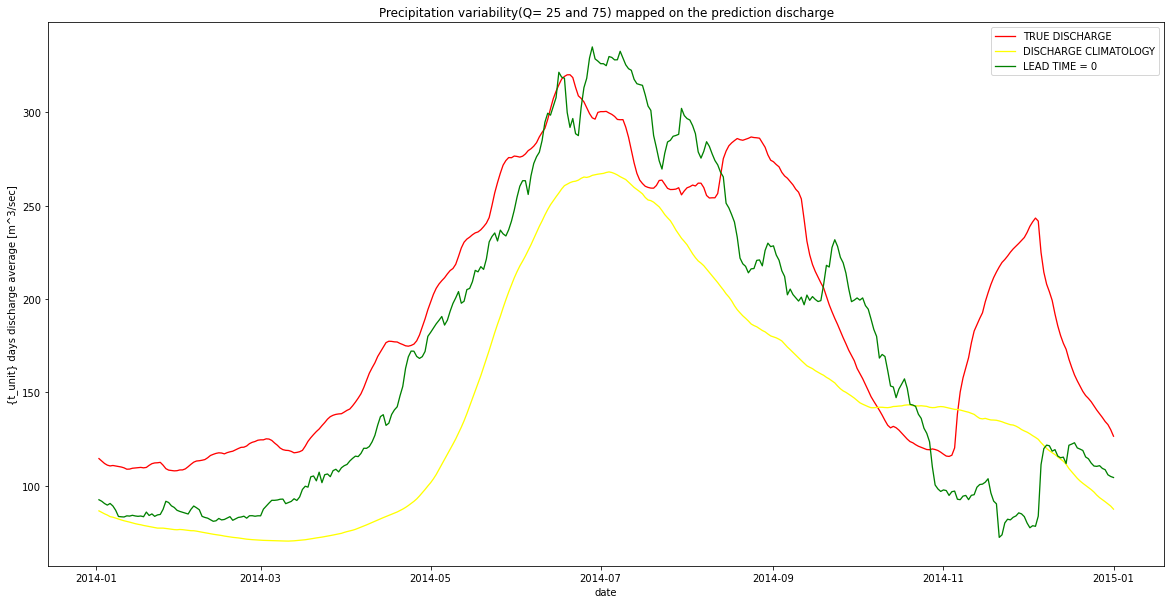

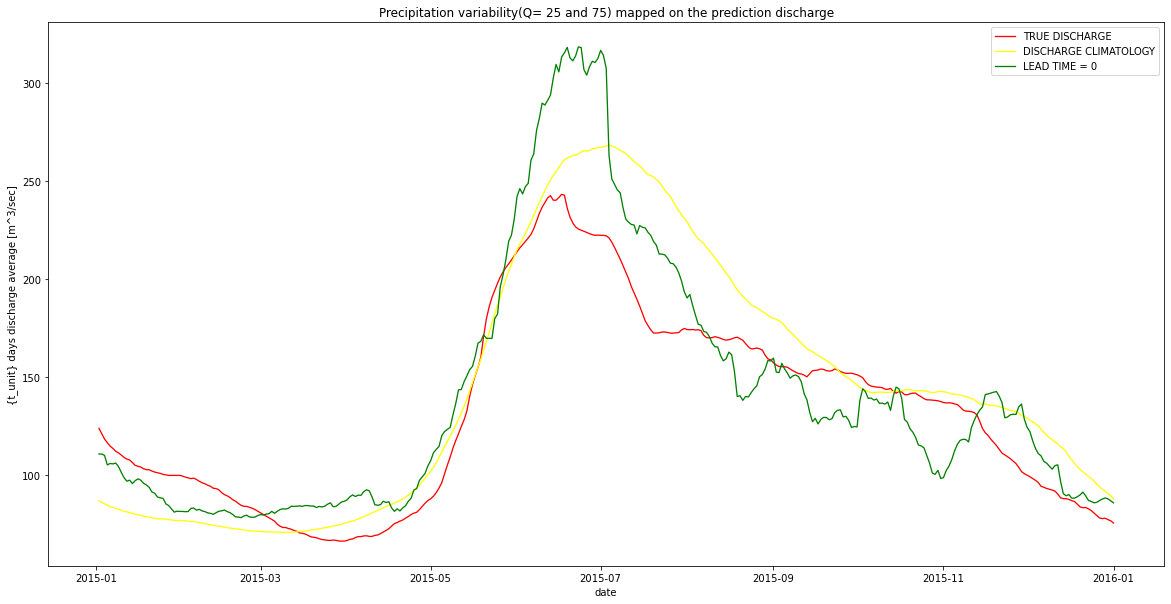

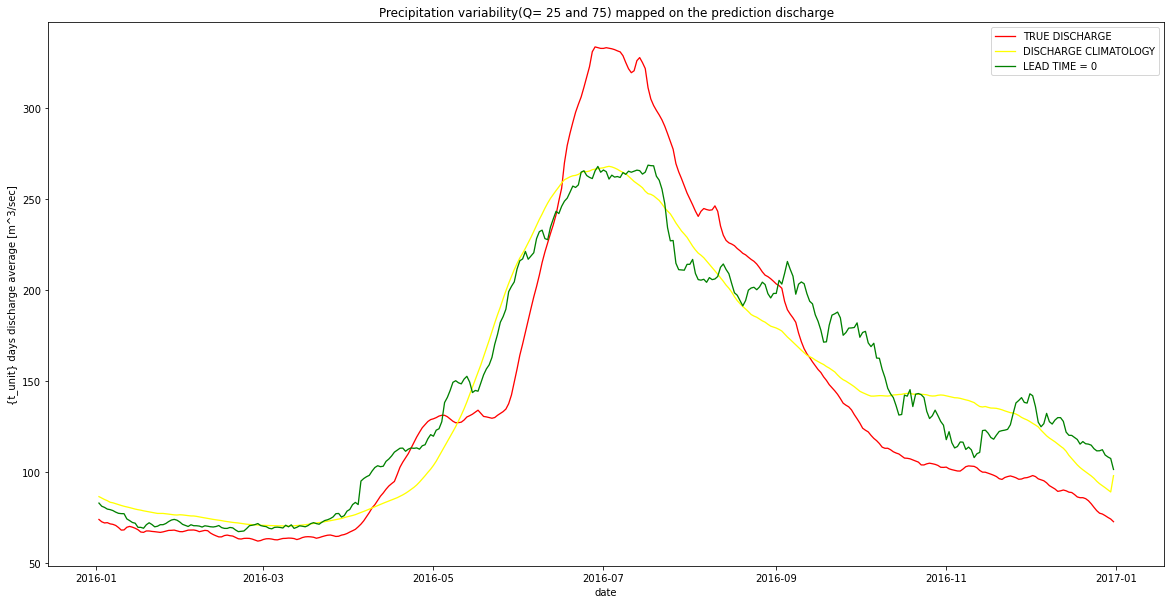

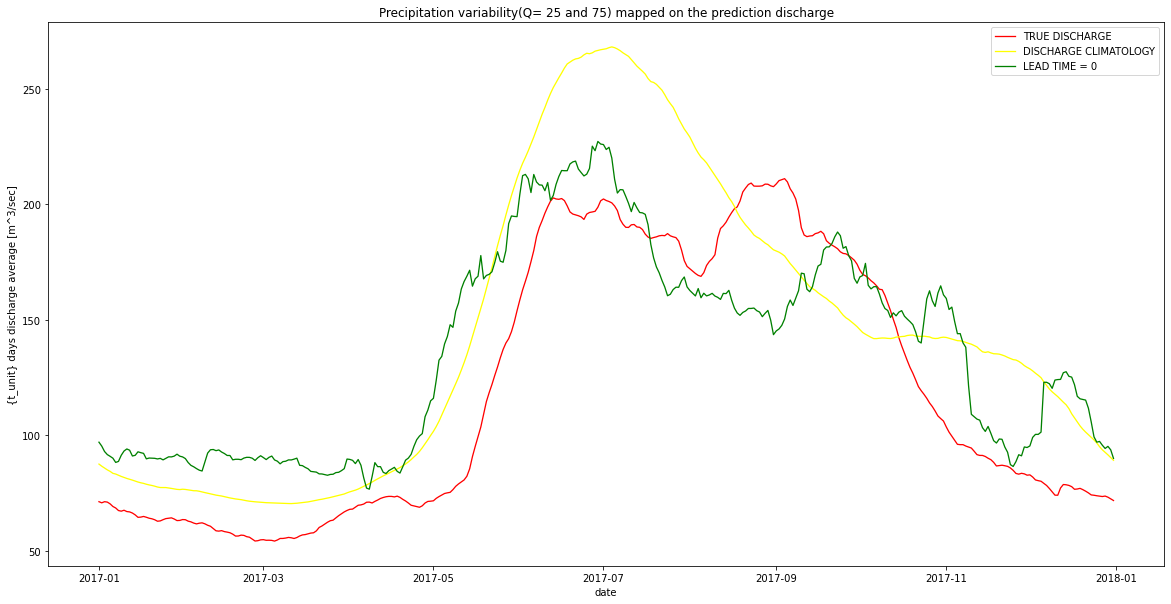

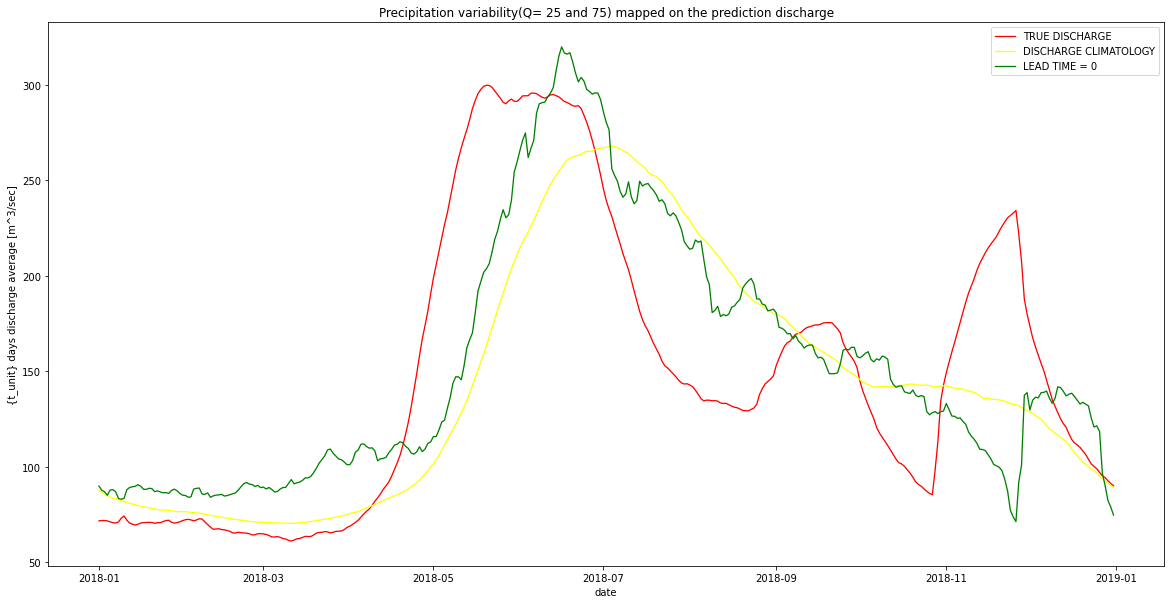

In [27]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3,t_unit)

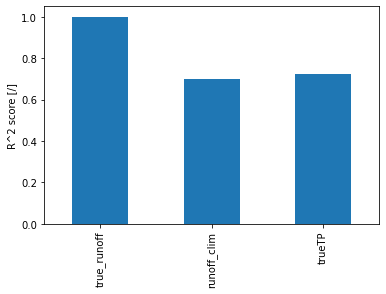

In [28]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3, 12, n_splits)

climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


In [ ]:
climatologies3=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3,t_unit)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C4=0.21544346900318823
eps4=0.1


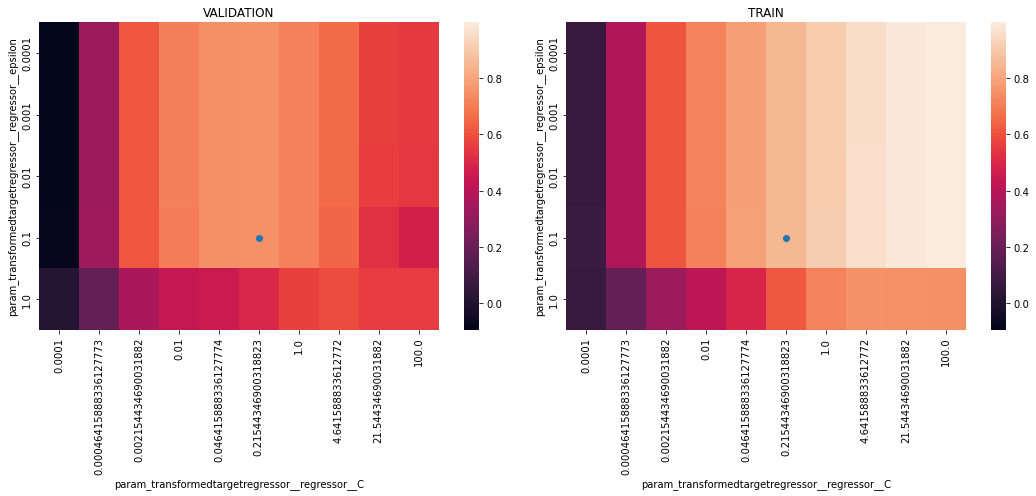

In [29]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C4={C4}')
print(f'eps4={eps4}')

In [30]:
C4=0.21544346900318834
eps4=0.01

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [31]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

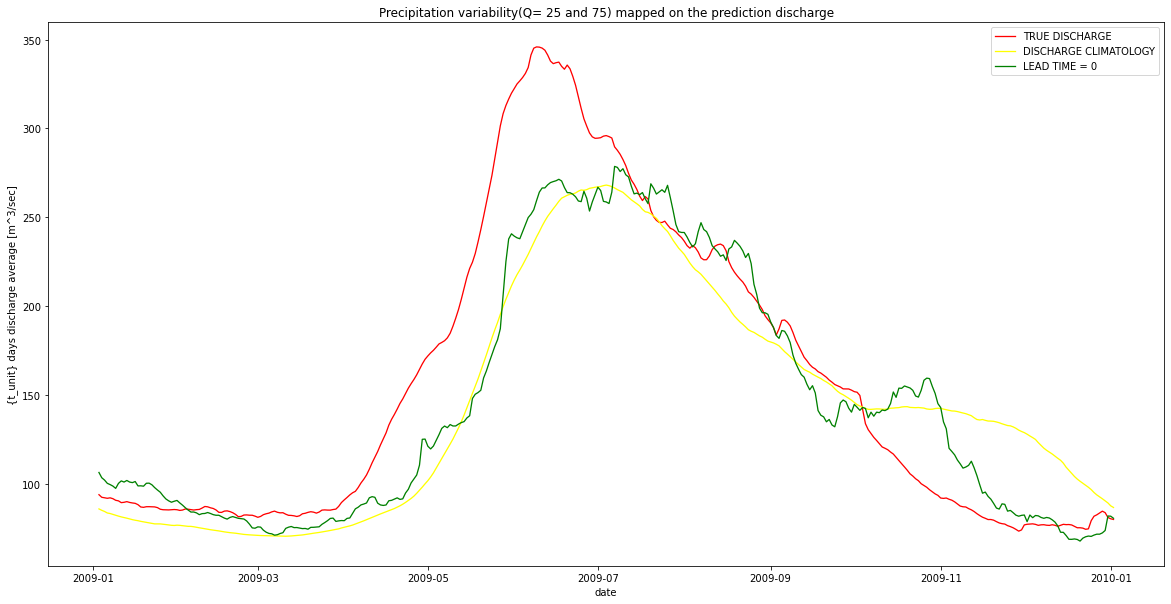

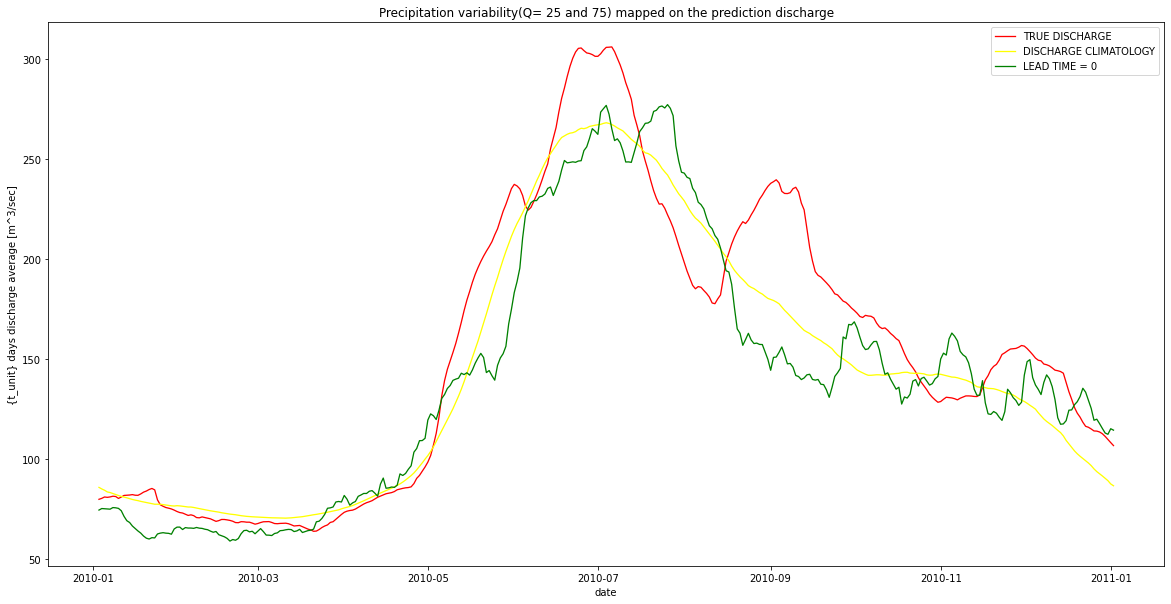

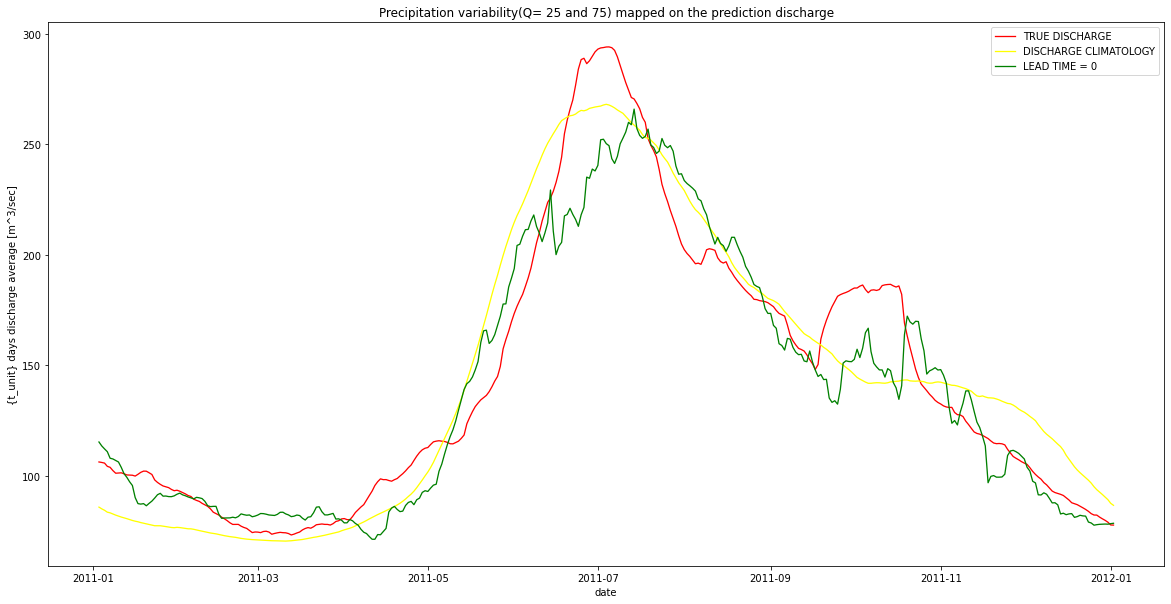

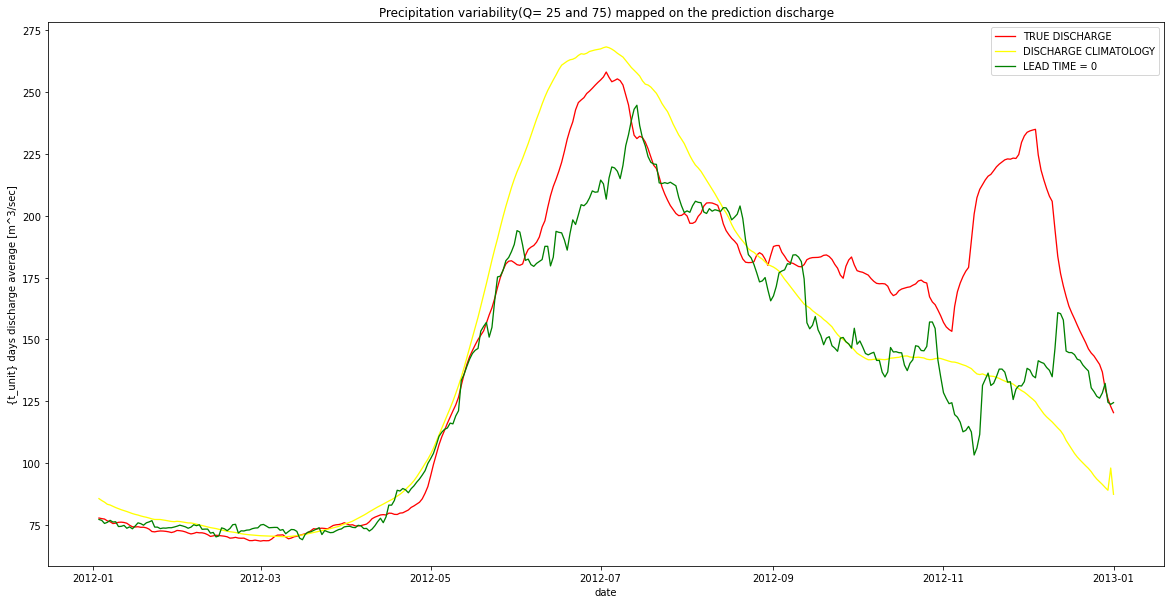

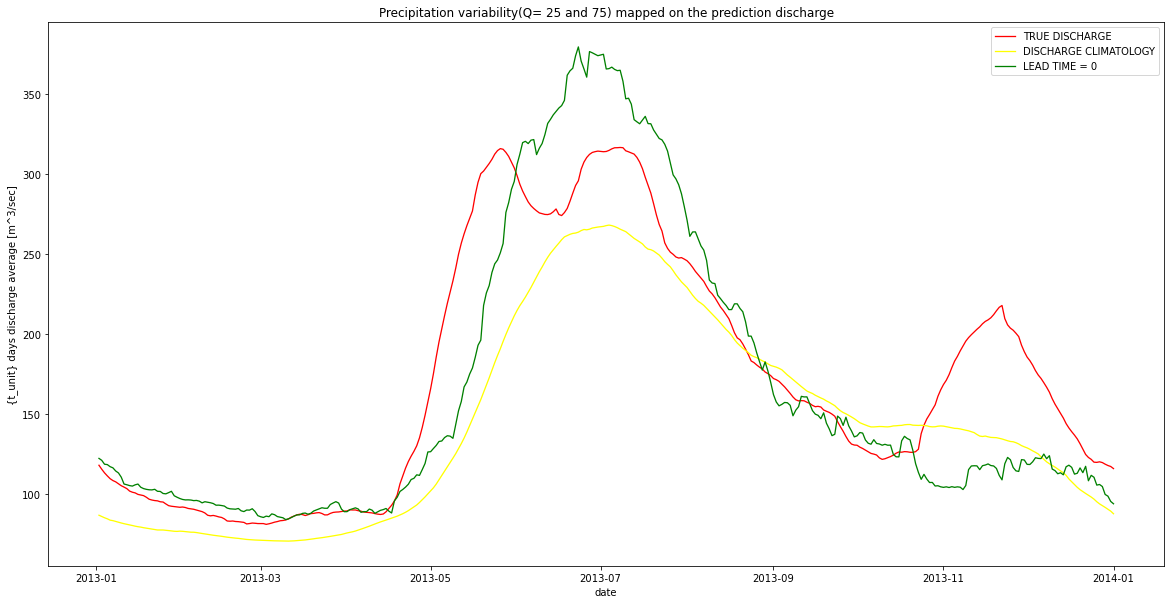

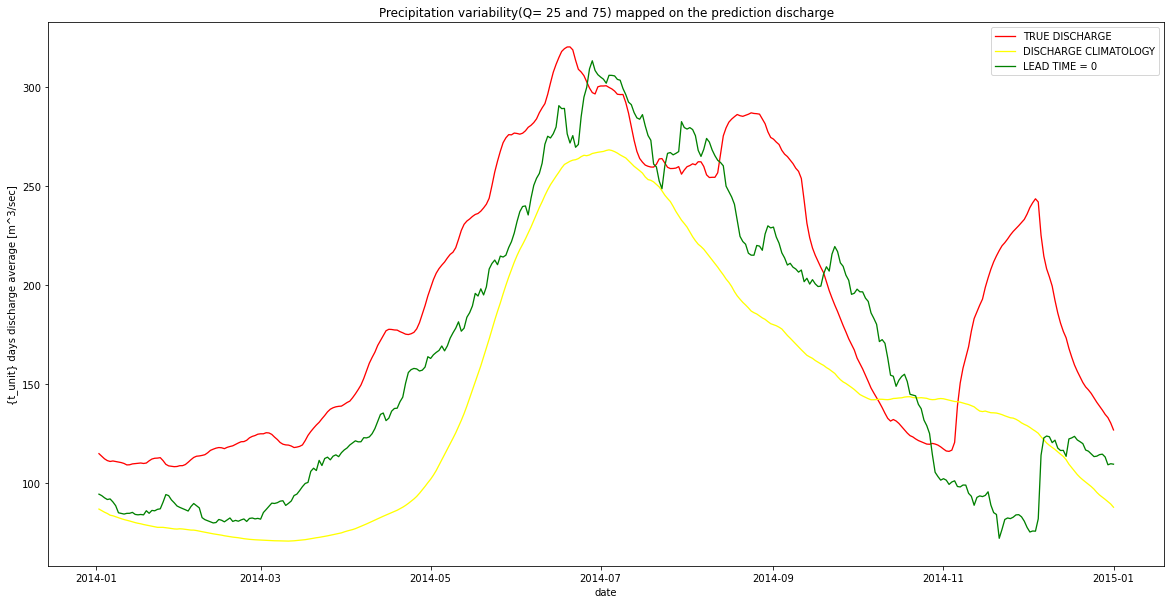

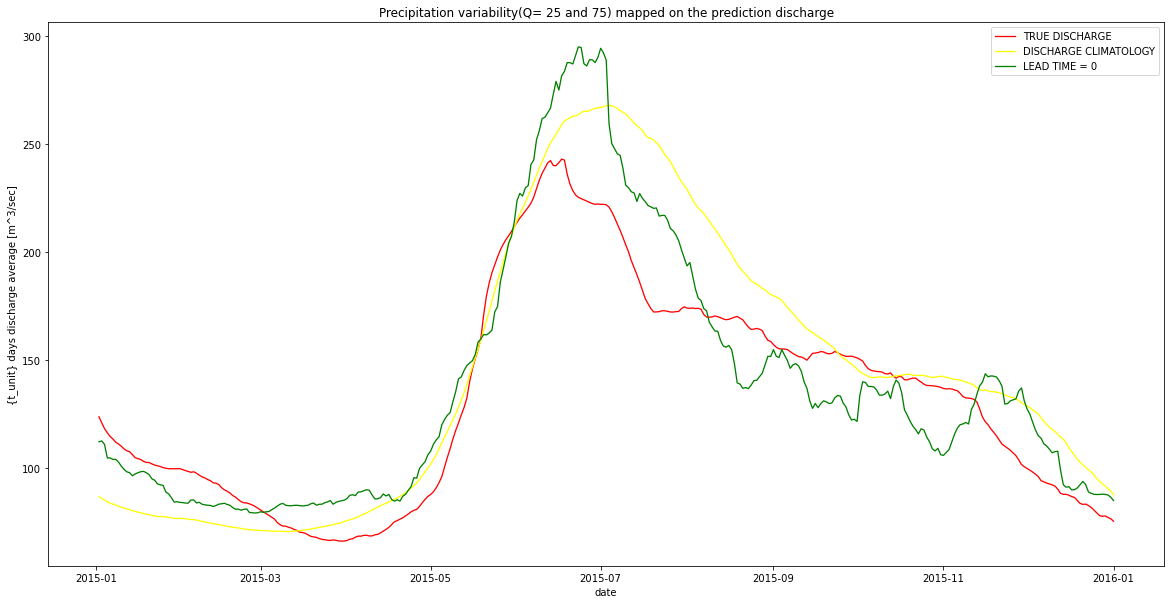

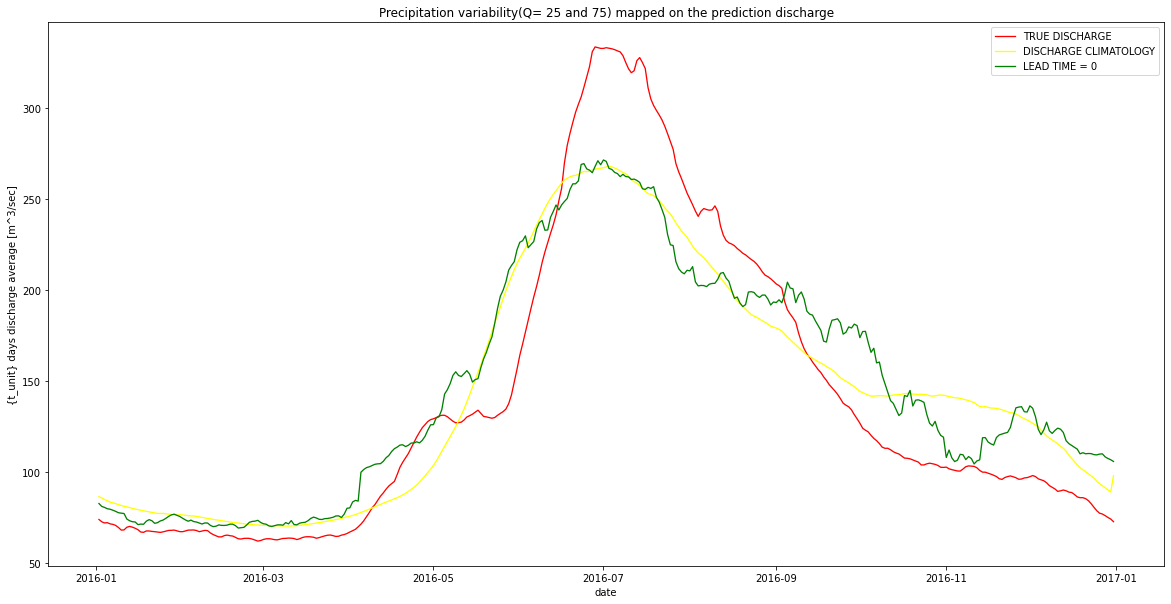

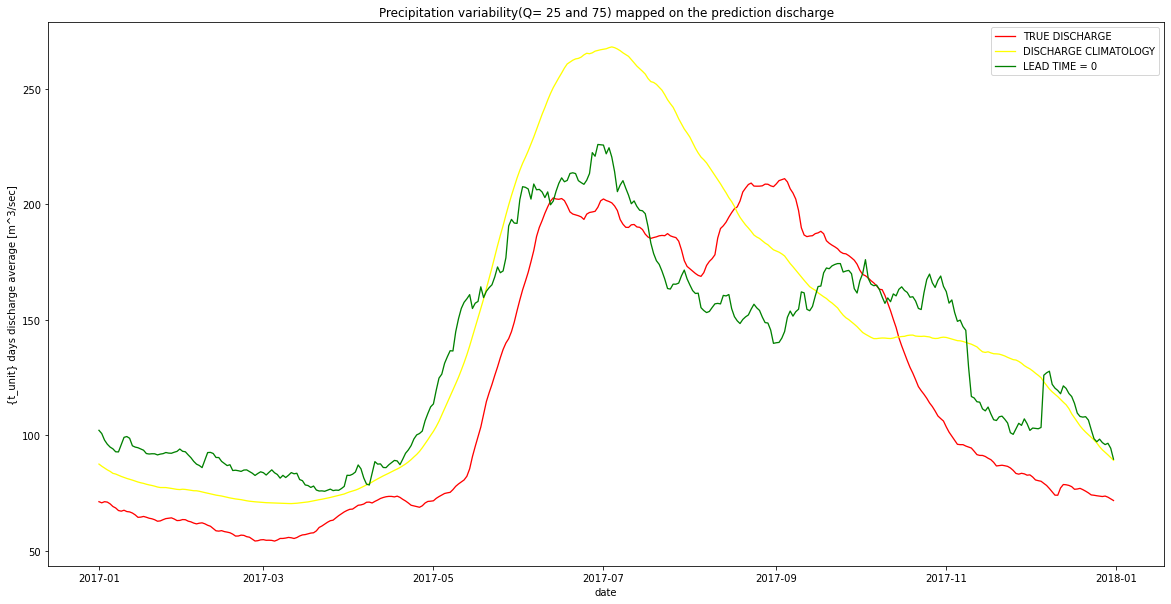

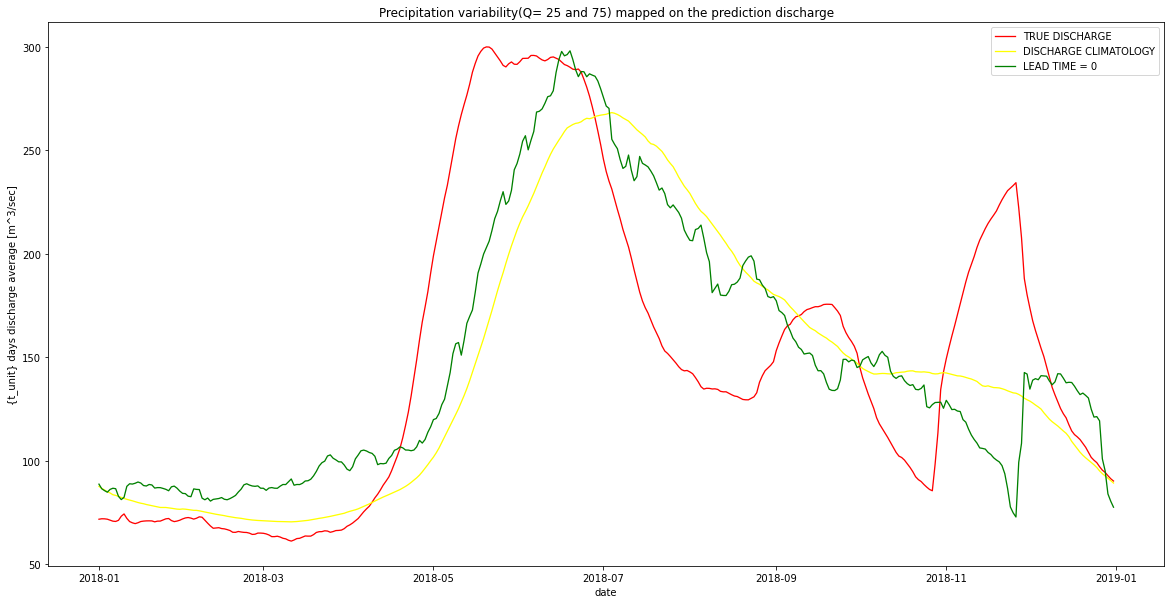

In [32]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4,t_unit)

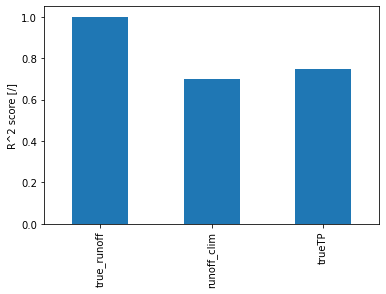

In [33]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4, 12,t_unit, n_splits)

climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


In [ ]:
climatologies4=climatologies

In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4,t_unit)

# COMPARE RESULTS

In [ ]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_STATS,r2_TPE],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

In [ ]:
r2_TPE_an = evaluate_prediction(a4)
r2_STATS_an= evaluate_prediction(a3)
r2_PCA36_an = evaluate_prediction(a2)
r2_PCA180_an = evaluate_prediction(a)

In [ ]:
results = pd.concat([r2_PCA180_an,r2_PCA36_an,r2_STATS_an,r2_TPE_an],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

In [ ]:
C5, eps5 = SVR_nested_CV_gridsearch(daily_input, C_range,epsilon_range, t_range,t_unit,n_splits,test_size,lt)
print(f'C4={C5}')
print(f'eps4={eps5}')

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits


In [ ]:
###### radius_for_ensemble = 1
predictions5 = nested_CV_SVR_predict(daily_input_stat, C5, eps5, 12,t_unit, n_splits, test_size, radius_for_ensemble,lt)

In [ ]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions5,t_unit)

In [ ]:
r2_5 = evaluate_prediction(predictions5)